# Transfer AE

_Use an autoencoder pre-trained on many sources as tranfer-learning preprocessing (feature extractor)._

## What?

![transferAE](transferAE.jpg)

## Why?

* Toute donnée est bonne à prendre (data driven). Les datasets s'entraident malgré la différence de leurs tâches. C'est la similitude entre les P(X) qui nous intéresse en premier lieu et aide par la suite à calculer les P(y|X) respectifs. Ainsi on peut tirer un avantage de données de sources très variées (different shapes and tasks).

* **Hypothèse : Il y a des connaissances générales communes à des données d'apparence éloignées.** L'espace des possibles est extrêmement grand. La "fenêtre" (sous-espace) ouverte par les données est très précises au final donc toute donnée affine un modèle (e.g. autoencoder). Autrement dit, l'ensemble des entrées plausibles est très petit.

* En gros on compresse des données pour les emmener avec soit.

**Plasticité : taux d'apprentissage de l'encoder (notamment pendant l'apprentissage d'un modèle).**

Pas forcément besoin d'une plasticité élevée pour bien généraliser?


L'AE apprend quelque chose de beaucoup plus général qu'un discriminant sur les données car il doit reconstituer l'information et non pas simplement répondre à une question dessus. **C'est une bonne chose pour généraliser mais il s'agit d'un problème beaucoup plus difficile, l'entrainement pourrait donc s'avérer moins efficace.**


## How?

# 1. Input shaper

On souhaite que le modèle puisse gérer des input data de differentes shapes.

* Soit un réseau capable de gerer des entrées de taille différentes;
* Soit un processing qui les mets au même format (padding and/or resizing)


#### One shape to rule them all

4D tensor : (row_count, col_count, channel, time)

In [1]:
# Imports
from data_manager import *
from model import *
from IPython.display import Image, SVG
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
tae = TAE(name='autoencoder', 
          shape=(1, 52, 52, 3), 
          load=True, save=True, 
          padding=False, verbose=False)

autoencoder.h5 loaded.
encoder initialized.
decoder initialized.


In [26]:
# Dataset list
# print(tae.datasets) # hidding datasets name for security reasons

In [18]:
#training_datasets = ['munster', 'loukoum', 'tristan']
training_datasets = ['beatriz']
testing_datasets = ['beatriz']

Shape: (1, 52, 52, 3)
Label: [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]


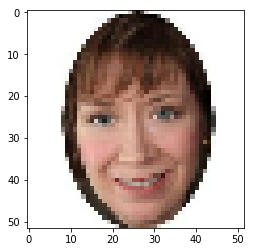

In [19]:
# Show an example
n = 0
dataset = training_datasets[0]
tae.show_example(dataset, n=n)

# 2. Autoencoder

Unsupervised, no task. Train on every datasets.

Plutôt que d'avoir un modèle génératif qui permet de faire de l'augmentation de données, celui-ci apprend une représentation abstraite des données.

In [20]:
# Train and save autoencoder
# Il serait interessant de tracer les courbes d'apprentissage sur les differents datasets simultanements
tae.metafit(training_datasets, 
        meta_epoch = 1,
        batch_size = 256,
        epochs = 1,
        steps_per_epoch = 10,
        test_size = 100)

Meta-epoch 1/1
Training on beatriz
Epoch 1/1
10/10 [==============================] - 26s 3s/step - loss: 139.3569 - val_loss: 116.8536
autoencoder.h5 saved.


Shape: (1, 52, 52, 3)


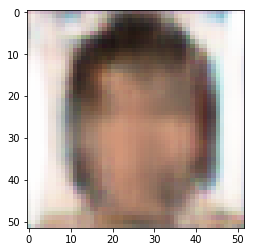

In [21]:
tae.show_reconstructed_example(dataset, n=n)

# 3. Model

Un discriminant unique pour chaque problème de chaque dataset.

In [22]:
# Train and evaluate model
tae.benchmark(testing_datasets,
              batch_size=256, 
              epochs=1, 
              steps_per_epoch=10, 
              test_size=200)

Testing on beatriz
Output dimension: 15
model initialized.
Epoch 1/1
10/10 [==============================] - 4s 413ms/step
[23.048552131652833, 1.0]


In [25]:
# To debug
# Model : SVM
#from sklearn.svm import SVC
#model = SVC(C=6, kernel='poly')
#tae.benchmark(testing_datasets, model=model, steps_per_epoch=1)

**Let's have fun generating images with the trained decoder!**

Shape: (1, 1, 52, 52, 3)


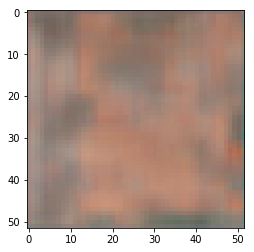

In [24]:
import numpy as np
noise =  np.float32(np.random.rand(1, 392))
tensor = tae.decoder.predict(noise)
show_example(tensor)